# Test to visualize how the dataset is built 

In [1]:
import torch
import random
import numpy as np
import skimage
import torchvision.transforms.functional as FT
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from PIL import Image
from skimage.transform import resize

In [2]:
ia.seed(1)

GREEN = [0, 255, 0]
ORANGE = [255, 140, 0]
RED = [255, 0, 0]

def pad(image, by):
    image_border1 = ia.pad(image, top=1, right=1, bottom=1, left=1,
                           mode="constant", cval=255)
    image_border2 = ia.pad(image_border1, top=by-1, right=by-1,
                           bottom=by-1, left=by-1,
                           mode="constant", cval=0)
    return image_border2

def draw_bbs(image, bbs, border):
    image_border = pad(image, border)
    for bb in bbs.bounding_boxes:
        if bb.is_fully_within_image(image.shape):
            color = GREEN
        elif bb.is_partly_within_image(image.shape):
            color = ORANGE
        else:
            color = RED
        image_border = bb.shift(left=border, top=border)\
                         .draw_on_image(image_border, size=2, color=color)

    return image_border

In [3]:
def thermal_image_preprocessing(image, split, bbox=None):
    '''
    Simple preprocessing for thermal images

    :param image: array image (h, w, c)
    :param mean: tensor of shape (1,)
    :param std: tensor of shape (1,)
    :param bbox: box coordinates of the object in the image (TODO : allow mutliple boxes)
    :return: torch tensor of shape (2, w, h) and float32 type
    '''
    image = np.expand_dims(np.array(image), axis=-1)

    # Standardization
    new_img = (image - image.mean()) / image.std()
    new_img = new_img.astype('float32')
    new_bbox = bbox
    #print(new_bbox)
    if split == 'TRAIN':
        new_img, new_bbox = data_augmentation(new_img, bbox)
        boxes = []
        for nb in new_bbox.bounding_boxes:
            boxes.append([nb.x1, nb.y1, nb.x2, nb.y2])
        new_bbox = torch.FloatTensor(boxes)

    # Reshape to (1, 300, 300)
    new_img = skimage.transform.resize(new_img, (300, 300))
    new_img = np.moveaxis(new_img, -1, 0)
    new_img = torch.FloatTensor(new_img)

    if bbox is not None:
        old_dims = torch.FloatTensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]]).unsqueeze(0)
        new_bbox = new_bbox / old_dims  # percent coordinates
        return new_img, new_bbox
    return new_img


def data_augmentation(image, bbox=None):
    list_box = []
    for box in bbox.tolist():
        list_box.append(BoundingBox(*box))
    bbs = BoundingBoxesOnImage(list_box, shape=image.shape)

    augmenters = [iaa.SomeOf((1, 3),
                             [iaa.Crop(percent=(0.1, 0.2)),
                              #iaa.Affine(rotate=(-30, 30)),
                              iaa.AdditiveGaussianNoise(scale=0.05 * np.max(image[0])),
                              iaa.OneOf([iaa.Dropout(p=(0.01, 0.2)),
                                         iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05))]),
                              iaa.Fliplr(1.0)],
                             random_order=True)
                  ]
    for i in range(50):
        seq = iaa.Sometimes(0.8, augmenters)
        if bbs:
            image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
            wrong_boxes = 0
            for bb in bbs_aug.bounding_boxes:
                bb_cliped_area = bb.clip_out_of_image(image_aug).area
                bb_area = bb.area
                # Si on crop plus de 20% d'une bbox lors du clip_out_of_image(), on recommence.
                if bb_cliped_area / bb_area < 0.8:
                    wrong_boxes += 1
            if wrong_boxes == 0:
                bbs_aug = bbs_aug.clip_out_of_image()
                break

    return image_aug, bbs_aug

In [4]:
import inspect

image = np.array(Image.open('/home/mathurin/prudence/datasets/dataset_mix/GLADIS5_grouped/Thermique/08_40_56_thermal.png', mode='r'))
list_bbox = []
box = torch.Tensor([[22, 1, 40, 45], [38, 37, 80, 59]])

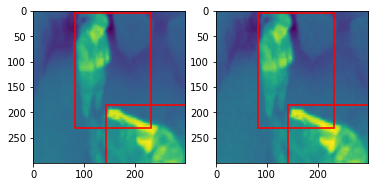

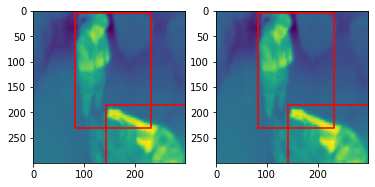

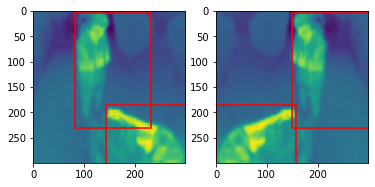

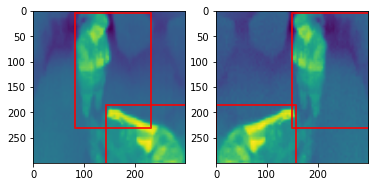

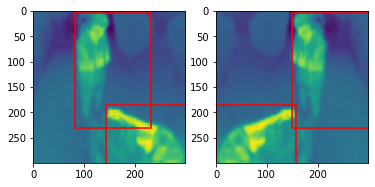

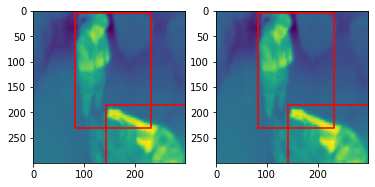

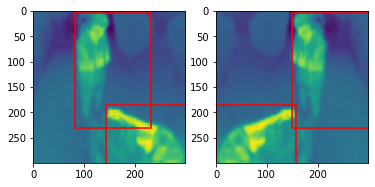

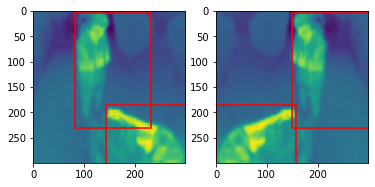

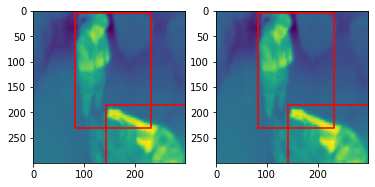

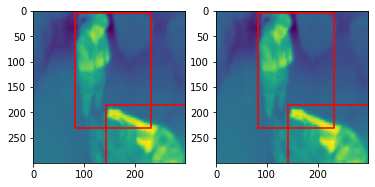

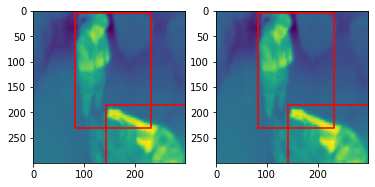

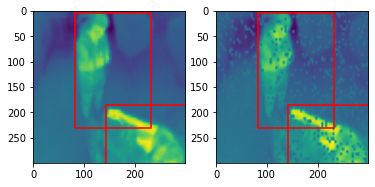

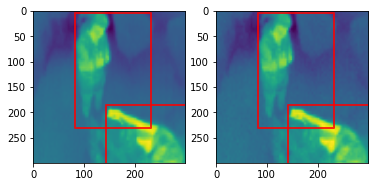

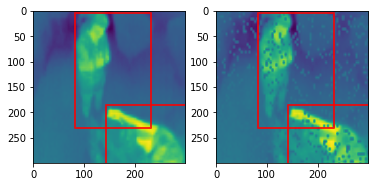

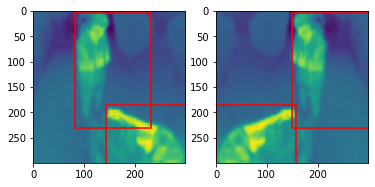

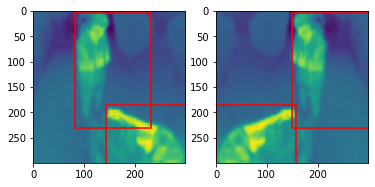

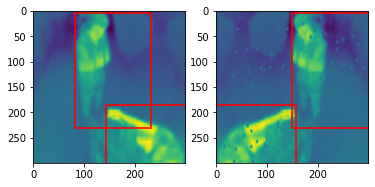

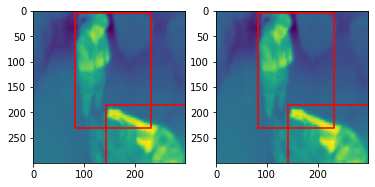

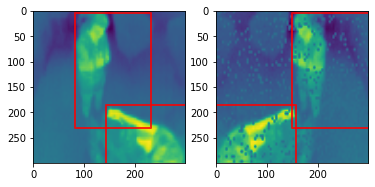

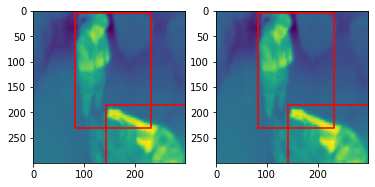

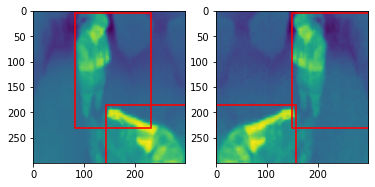

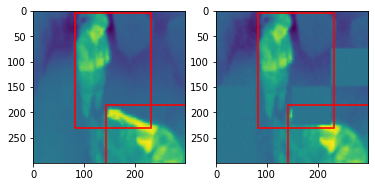

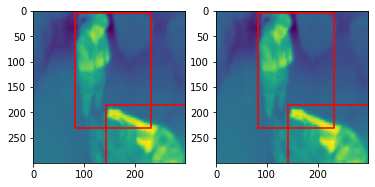

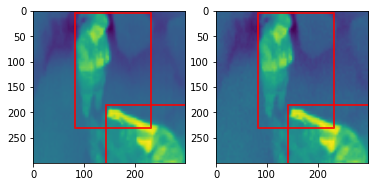

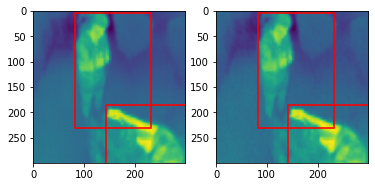

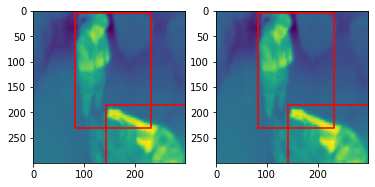

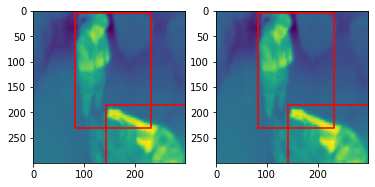

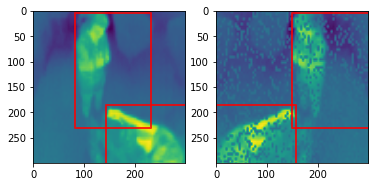

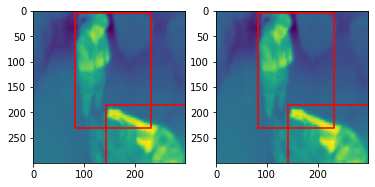

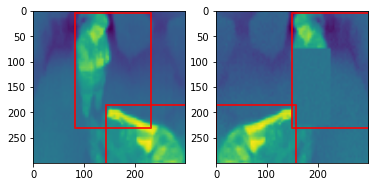

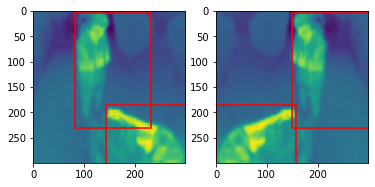

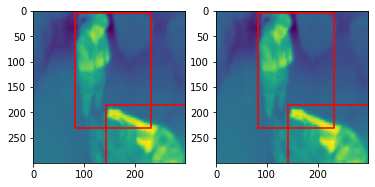

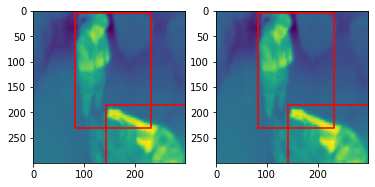

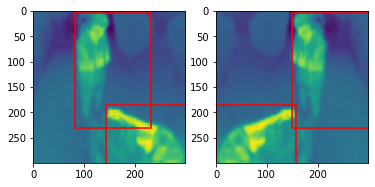

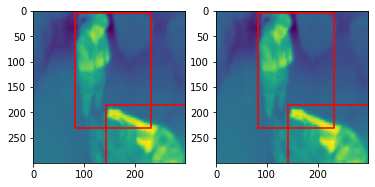

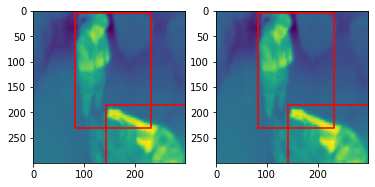

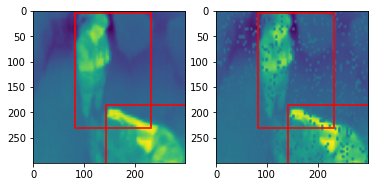

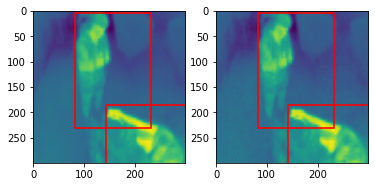

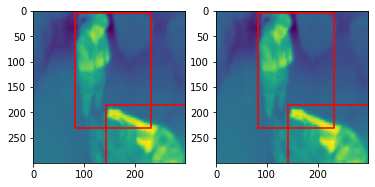

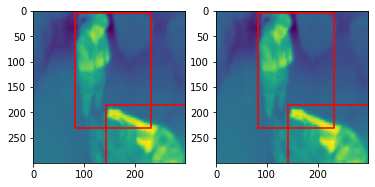

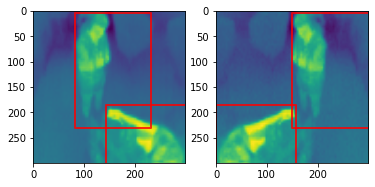

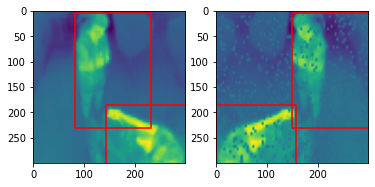

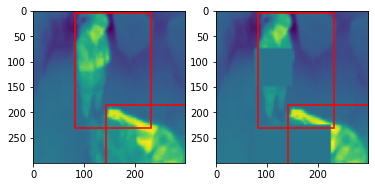

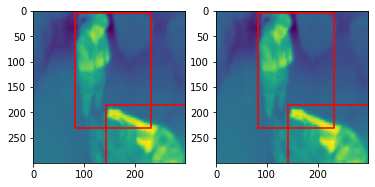

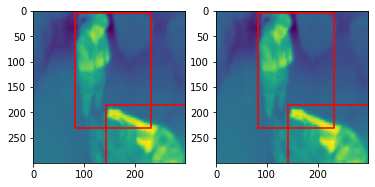

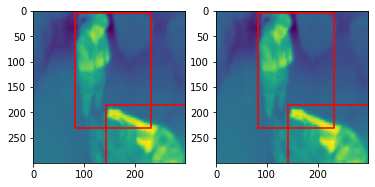

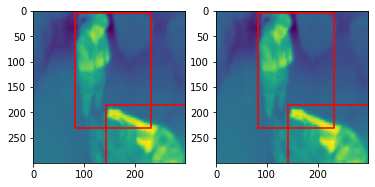

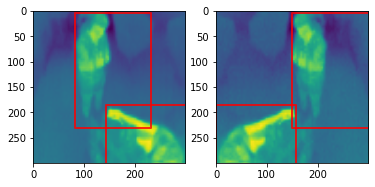

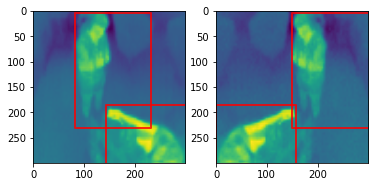

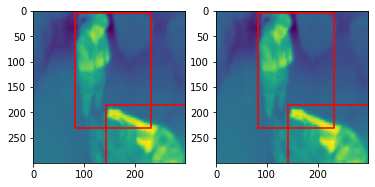

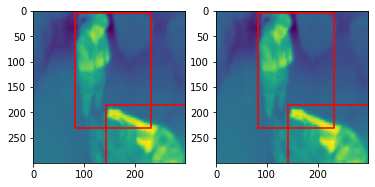

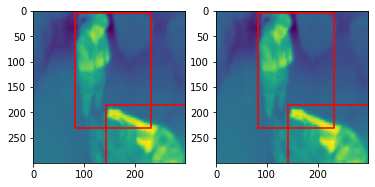

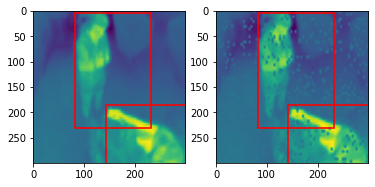

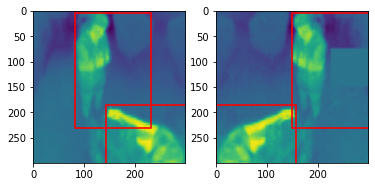

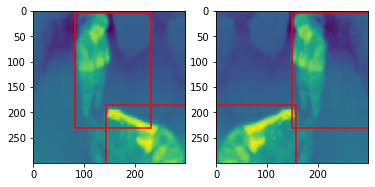

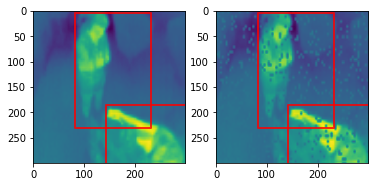

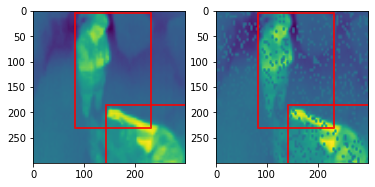

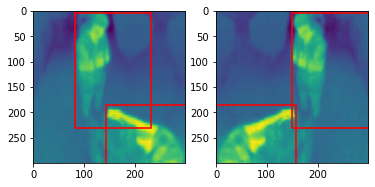

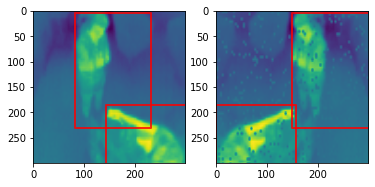

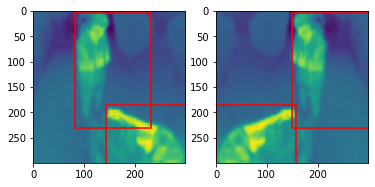

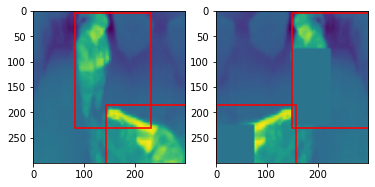

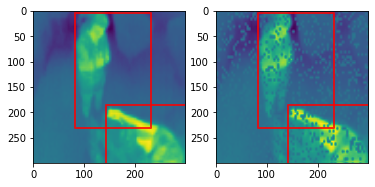

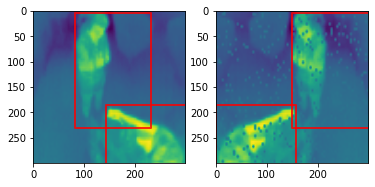

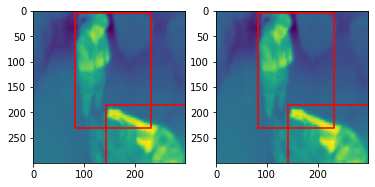

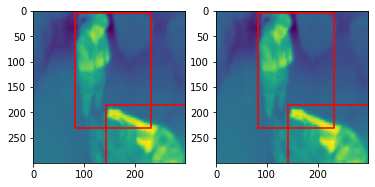

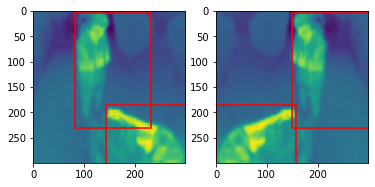

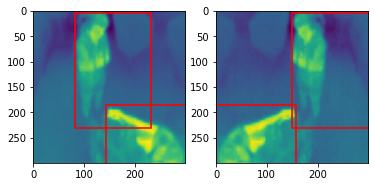

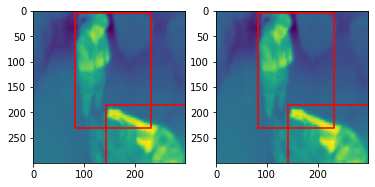

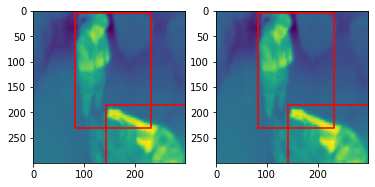

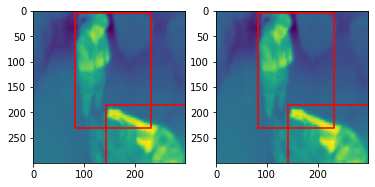

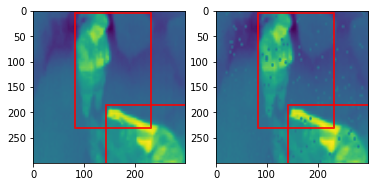

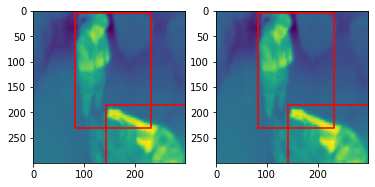

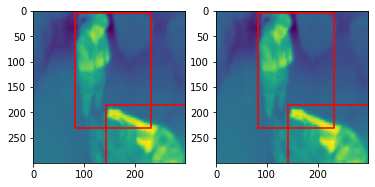

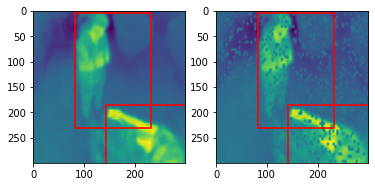

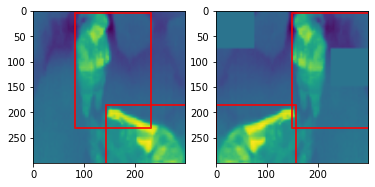

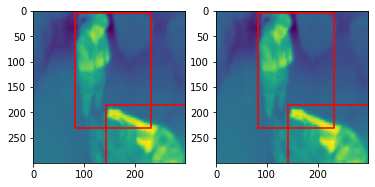

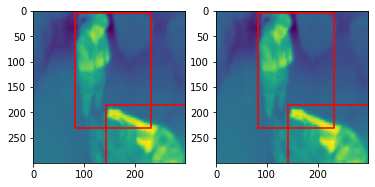

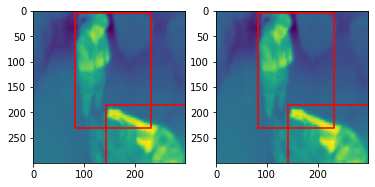

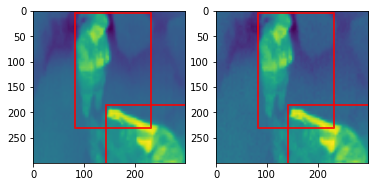

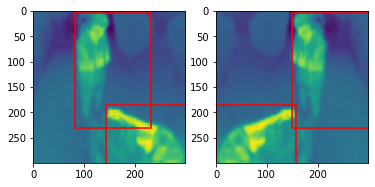

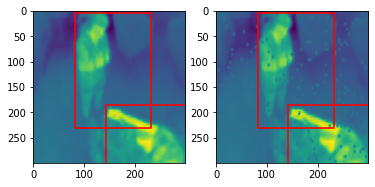

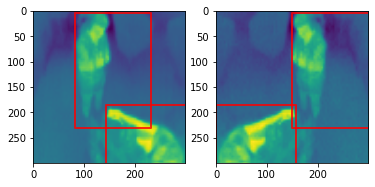

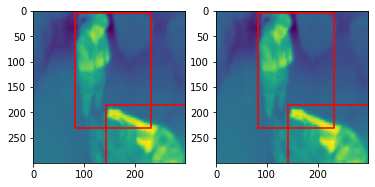

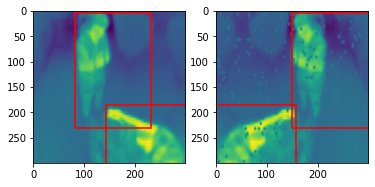

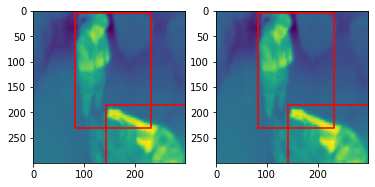

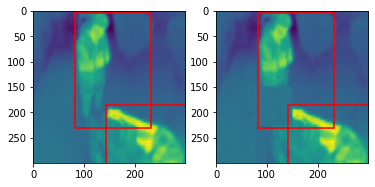

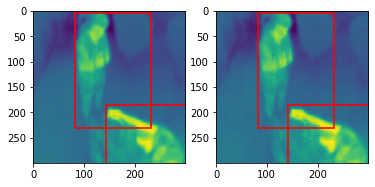

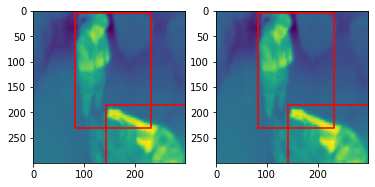

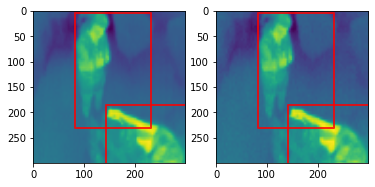

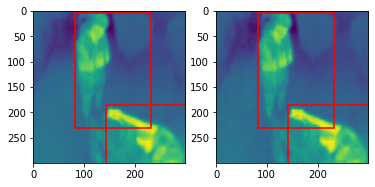

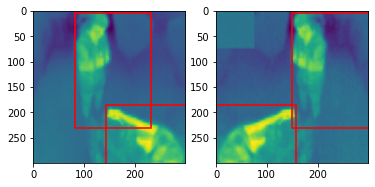

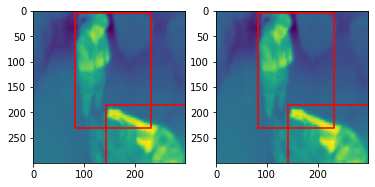

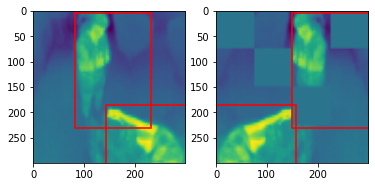

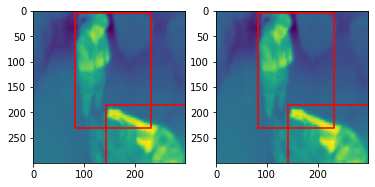

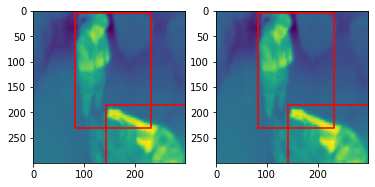

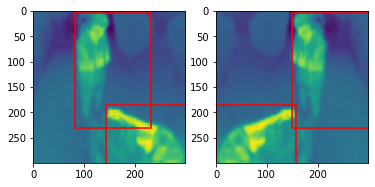

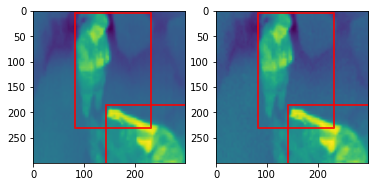

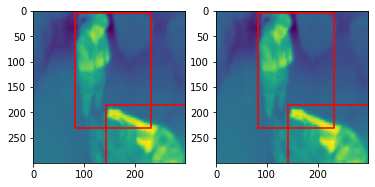

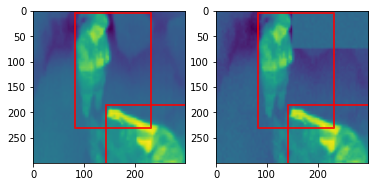

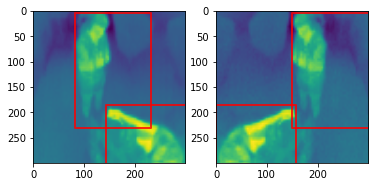

In [6]:
for i in range(100):
    rects = []
    rects_aug = []
    new_img, new_bb = thermal_image_preprocessing(image, split='TRAIN', bbox=box)
    new_img = new_img.numpy().squeeze()
    
    # Ground truth bbox
    old_dims = torch.FloatTensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]]).unsqueeze(0)
    box_resized = box / old_dims  # percent coordinates
    
    box_resized = box_resized*300
    box_resized = box_resized.tolist()
    for bb in box_resized:
        rects.append(patches.Rectangle((bb[0], bb[1]), bb[2], bb[3]))
    
    pc = PatchCollection(rects, facecolor='none', alpha=0.8,
                             edgecolor='r', linewidth=2)
    
    # Predicted bbox
    new_bb = new_bb * 300
    new_bb = new_bb.tolist()
    for bb in new_bb:
        rects_aug.append(patches.Rectangle((bb[0], bb[1]), bb[2], bb[3]))
    
    
    pc_aug = PatchCollection(rects_aug, facecolor='none', alpha=0.8,
                             edgecolor='r', linewidth=2)
    

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.add_collection(pc)
    ax1.imshow(resize(image, (300, 300)))  
    ax2.add_collection(pc_aug)
    ax2.imshow(new_img)
    plt.show()